### Written response

This notebook has the following sections:
1. [[EDA]](#eda) - Exploratory Data Analysis. Contains detailed explanations on my thought process and choices.
1. [Imports and globals](#imports-and-globals)
1. [Build dataset](#build-dataset)
1. [Train](#train)
1. [Test](#test)


---
<u>**Response to Task 3(a)**</u>

On `audio` **preprocessing** and **feature extraction**, I chose to perform the processing as described in `ASRModel.preprocess__common_voice()` (See `src/app/model.py`).
1. Ensured all audio is mono as the model accepts only mono and not stereo.
1. Standardized the peak amplitude to 0dB to ensure very soft audio are appropriately amplified for feature extraction.
1. Snipping the mp3 to only the first utterance segment. After examining the Common Voice dataset (esp. the long mp3s), I find that the main reason why mp3s are long is mainly because the annotators forgot to turn off their microphone before reading out their lines.
1. Audio that has near-total silence throughout are excluded from the dataset.
1. Frame rate is re-sampled to 16kHz as required by the input of the model.

On `text` **preprocessing** and **feature extraction**, I mainly checked which tokens are supported (e.g. uppercase chars, `'`, space) and cleaned the raw text to that.

On **tokenizer**, I chose to use `Wav2Vec2Processor`'s, since we're fine-tuning its corresponding model.

On **pipeline processes**,
1. Did a **train-validation-split** by **stratified** split based on the available speaker information. (Refer to [[EDA]](#eda) for more details)
    1. In the dataset, rows are excluded if they (1) don't have majority up votes, or (2) are total silence (cannot pass the silence splitting preprocessing).
1. Chose to use `datasets` `Dataset` to store my data as it facilitates multiprocessing for proprocessing, thus saving time. It also facilitates batching easily.
1. Built a helper class around `torch.utils.data.DataLoader` called `CommonVoiceDataLoader` (See `src/utils_train/`). This allows me to pre-fetch batches of data beforehand, making the training process more efficient.
1. Chose **batch_size** = 8. With **AMP (Auto Mixed Precision) training**, I am already hitting 10GB/11GB of my Nvidia 2080Ti. Ideally, I would like at least 16 as it would make model updates smoother. (I could have applied gradient accumulation, but this would further complicate my code, opening up more surface areas for bugs in a time-constrained setting).
1. Chose a relatively low **learning rate** at 8e-4 (Same as the rate used for fine-tuning by Karima et. al.).
1. Chose an **epochs** = 10. For fine-tuning, I'm already using a relatively low learning rate, so it pays to be patient and train for longer. I checkpoint for the model with best WER too, so I can manually stop training as appropriate.
1. **Froze the base_model**. Number of trainable parameters reduced from 315m to 0.328m. This greatly speeds up model training, as I can train with a decent batch size without worries of GPU OOM (Out of Memory). This also translates to quicker development feedback cycle.
    1. The other option is to freeze the feature_encoder, but total number of trainable model parameters remain very high at 311m (reduced from 315m), making it inappropriate for my low-resource GPU.
    1. Furthermore, I view the task of fine-tuning on Common Voice dataset as an adaptation to the data distribution for a new specific use case. If we 'feel' (intuition) that the model has already formed a good understanding / good inner-model of how audio interacts with the text (think pre-training), then we shouldn't allow this narrow task to potentially pollute/confuse the inner model. Hence it is fine that we don't modify the underlying feature and, to-some-extent, the encoder.
1. As validation dataset is quite large 30%, to have a good balance of training speed vs sufficient validation metrics, I log training metrics only roughly every 20% of an epoch.
1. Refer to the screenshot below on the **metrics collected during training**.
    1. Validation loss is on a downward trend, which is clear for the 500k steps, going down together with training loss. This implies that the model is 'generalizing' / adapting to the new Common Voice domain.
    1. Validation loss seems to plateau thereafter, with very minute downward trend. This suggests that the training is hitting a limit, which could have a variety of possible causes (e.g. too few parameters having limited degree of freedom to update weights; batch size is too small/frequent, leading to erratic information gained per batch; the dataset is similar to Librispeech, etc.)
    1. Validation loss has a periodic spike up before going down, albeit with a mild downward trend. I view this fairly positively, as it implies that the model is overcoming little 'hills' in the optimization landscape and to try other minimas.
    1. WER also had a downward trend, though noisily, till around 800k steps. It is noteworthy that around 1.2M steps, the WER (0.1338) got very very close to the final saved model's WER (0.1330). However, the training ended before it can reach achieve even lower WER.

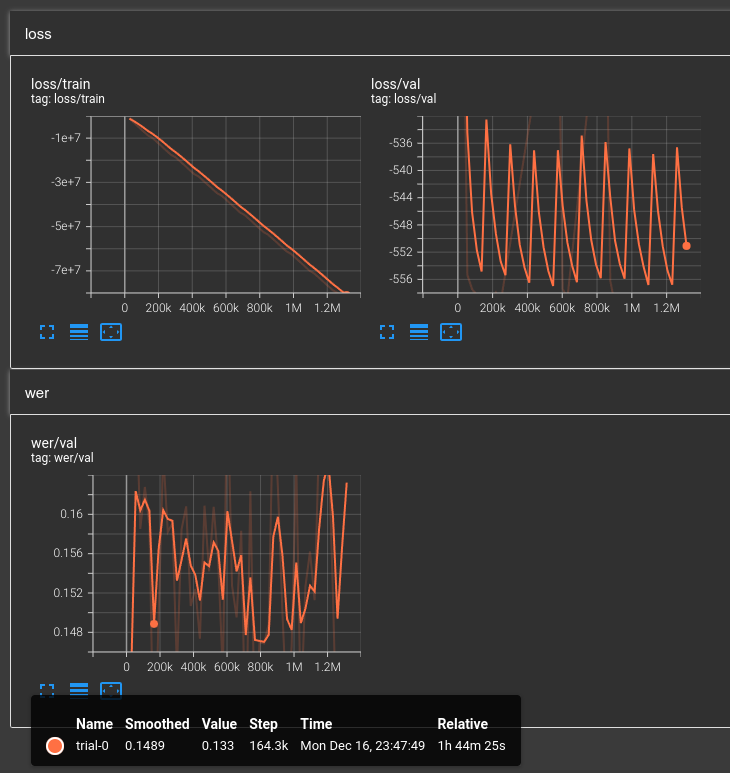


---
<u>**Response to Task 3(c)**</u>
1. WER = 0.13266 on test set
1. For qualitative analysis of prediction vs ground truth, please refer to: [Test](#test)

### Imports and globals

In [8]:
import os
import sys
from pathlib import Path

PROJECT_DIR = Path.home() / "work/htx-xdata"  # TODO change this to the path of your repo
TASK_DIR = PROJECT_DIR / "asr-train"
src_dir = TASK_DIR / "src"


if src_dir.as_posix() not in sys.path:
    sys.path.insert(0, src_dir.as_posix())
# NOTE: You may also want to add `"python.analysis.extraPaths": ["./asr-train/src"]` to your VSCode workspace

In [ ]:
import json
import logging
import re
import shlex
from functools import partial
from io import BytesIO
from pathlib import Path
from subprocess import check_output
from typing import List, Tuple

import evaluate
import numpy as np
import pandas as pd
import torch
from app.config import (
    best_checkpoint_dir,
    ds_dev_dir,
    ds_test_dir,
    ds_train_dir,
    ds_val_dir,
    final_model_dir,
    pth_df_wer_test,
    pth_model,
    pth_processor,
    pth_valid_dev_raw,
    pth_valid_test_raw,
    pth_valid_train_raw,
    sampling_rate,
    valid_dev_raw_dir,
    valid_test_raw_dir,
    valid_train_raw_dir,
)
from app.model import ASRModel
from datasets import Dataset, load_dataset
from pydub import AudioSegment
from sklearn.model_selection import train_test_split
from utils_ds import (
    array_to_audio,
    backup_file,
    disp_audio,
    get_df_valid_dev,
    get_df_valid_test,
    get_df_valid_train,
    get_df_wer,
    get_ds_cur_chunk_dir,
    get_ds_fingerprint_chunk,
    load_ds_from_disk,
    preprocess_text,
    save_best_model,
)
from utils_train import CommonVoiceDataLoader, batch_predict, count_parameters

pd.options.display.max_colwidth = 100


def process_row(row, mp3_dir: Path):
    """
    Process a single row for use in Dataset.map.

    NOTE: Must be defined in Notebook to circumvent serialization issues with `Dataset.map()` for `asr` model.
    Args:
        row (dict): A row from the dataset containing 'filename' and 'text'.
        mp3_dir (Path): Path to the directory containing the mp3 files.
    Returns:
        dict: A dictionary with processed 'filename', 'text', and 'audio', or None if processing fails.
    """
    global asr
    pth = mp3_dir.parent / row["filename"]  # Construct full path

    # Preprocess audio
    audio, np_array = asr.preprocess__common_voice(pth, "mp3")
    if audio is None:
        logging.warning(f"Unable to preprocess audio -> discarding: {pth}")
        return {
            "filename": row["filename"],
            "text": "",
            "audio": np.ndarray(0, dtype=np.float32),
        }

    # Preprocess text
    text = preprocess_text(row["text"])

    return {
        "filename": row["filename"],
        "text": text,
        "audio": np_array,
    }

In [ ]:
if not pth_processor.exists():
    from transformers import Wav2Vec2Processor

    processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
    processor.save_pretrained(pth_processor)
if not pth_model.exists():
    logging.info("Downloading model")
    from transformers import Wav2Vec2ForCTC

    model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")
    model.save_pretrained(pth_model)

In [ ]:
RUN = False
# RUN = True
if RUN:
    # for baseline comparison only
    ds = load_dataset("patrickvonplaten/librispeech_asr_dummy", "clean", split="validation")

    asr = ASRModel()
    model = asr.model
    processor = asr.processor
    device = asr.device
del RUN

### [EDA]

In [4]:
# [comments]
# Referring to both the `processor.tokenizer.vocab` as well as online resources like https://huggingface.co/learn/audio-course/en/chapter3/ctc
# The vocab of the model is just uppercased letters, space "<s>" and apostrophe ".".
# Also, numbers are spelled out, e.g. "one" instead of "1".
# HOWEVER, the dataset doesn't contain any numbers. As there are a lot more tasks to complete, I'm going to keep this for future improvements.


## [EDA] Check for numbers in the dataset
RUN = False
if RUN:
    df_eda = pd.concat(
        [
            pd.read_csv(pth_valid_dev_raw),
            pd.read_csv(pth_valid_train_raw),
            pd.read_csv(pth_valid_test_raw),
        ],
        ignore_index=True,
    )
    assert (
        df_eda["text"].str.match(".*\d+.*").any() == False
    ), "Dataset contains numbers in text! Need to add preprocessing for numbers"
del RUN
# ## [KIV] Preprocessing for numbers to words
# (dataset doesn't contain such numbers, so save for future work)
# # Regex for ordinals like 1st, 2nd, 3rd; [ss]
# rgx_ordinal = re.compile(r"\b\d+(st|nd|rd|th)\b", re.IGNORECASE)
# # Regex for numbers
# rgx_number = re.compile(r"\b\d+\.\d+\b|\b\d+\b")
# import inflect
# inflect_engine = inflect.engine()
# inflect_engine.number_to_words(100001.2) # Handle integers / floats
# inflect_engine.number_to_words("1st") # Handle ordinals

In [5]:
# ## [debug] Check that the text is correctly preprocessed / tokenized
# inp = processor(
#     ds[0]["audio"]["array"],
#     text=preprocess_text("Because you were sleeping instead of conquering, the lovely Rose Princess has become a fiddle without a bow, while poor Shaggy sits there a cooing dove!"),
#     return_tensors="pt",
#     # padding="longest",
#     sampling_rate=sampling_rate,
# )
# assert (
#     processor.tokenizer.convert_tokens_to_string(
#         processor.tokenizer.convert_ids_to_tokens(inp["labels"][0]), group_tokens=False
#     )["text"]
#     == ds[0]["text"]
# )

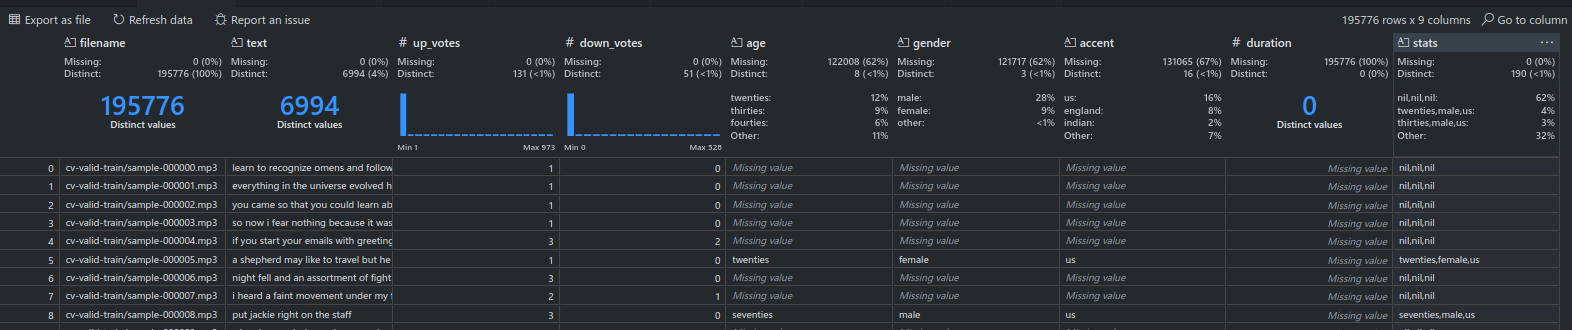

In [6]:
# [comments]
# (1)
# Majority of the speaker's information are missing (age, gender, accent)
# Referring to the screenshot above on the `stats` column, the highest occuring category of speakers is 'twenties,male,us' at a measly 4%
# Nevertheless, we can still do a best-effort stratified split based on the available information. We will stratify based on the `stats` column
#
# (2) From Common Voice webste https://www.kaggle.com/datasets/mozillaorg/common-voice , every mp3 has gone through at least 2 listeners to evaluate.
# However, it is clear from the `up_votes` and `down_votes` column that while there are 2 listeners, in sizeable number of cases, some listeners did not cast a vote.
# A whoping 39.8% of the dataset are the "1 upvote, 0 downvote" case (`df.query('down_votes ==0 and up_votes == 1').shape[0] / df.shape[0]`)
# This means that we should not exclude such cases, since our dataset is already not very large.
#
# (3) The numer of cases where down_votes >= up_votes is negligible (`df.query('down_votes >= up_votes').shape[0] / df.shape[0]`). And doesn't affect the overall dataset size.

## [EDA] check dataset (using VSCode Data Wrangler extension)
RUN = False
if RUN:
    df_eda = get_df_valid_train(remove_majority_downvotes=False)
del RUN

### Build dataset

In [7]:
# RUN = False
RUN = True  # NOTE
if RUN:
    df = get_df_valid_train()

    # Remove categories with only 1 speaker
    srs = df["stats"].value_counts()
    assert srs[srs <= 1].sum() < 10, "Sizeable category of speakers require additional handling before stratified split"
    df = df[df["stats"].isin(srs[srs > 1].index)].copy()

    df_train, df_val = train_test_split(
        df,
        test_size=0.3,
        stratify=df["stats"],
        random_state=77,
    )
    df_test = get_df_valid_test()
    df_dev = get_df_valid_dev()
del RUN

In [8]:
## [EDA] Manually validate and tune the preprocessing
# [part1] Data-prep
RUN = False
if RUN:
    lst = [(pth, pth.stat().st_size) for pth in valid_train_raw_dir.glob("*.mp3")]
    df_eda = pd.DataFrame(lst, columns=["pth", "size"]).sort_values("size", ascending=False).head(10)
    filenames_eda = df_eda["pth"].apply(lambda x: x.relative_to(valid_train_raw_dir.parent).as_posix())
    audios = [AudioSegment.from_file(pth, format="mp3") for pth in df_eda["pth"]]
    audio_norms = [asr.preprocess__common_voice(pth, "mp3")[0] for pth in df_eda["pth"]]
del RUN

# [part2] EDA
RUN = False
if RUN:
    i_pth = 2
    pth = df_eda.iloc[i_pth]["pth"]
    filename = pth.relative_to(valid_train_raw_dir.parent).as_posix()
    audio = audios[i_pth]
    audio_norm = audio_norms[i_pth]
    display(df.query("filename == @filename"))
    display(audio[: int(60e3)])
    display(audio_norm)
del RUN

In [9]:
## Build the dataset
# RUN = False
RUN = True  # NOTE

if RUN:
    asr = ASRModel()

    ds_chunk_size = int(10e3)

    for df_cur, ds_cur_dir, ds_fingerprint_pfx, mp3_dir in [
        (df_val, ds_val_dir, "ds_val", valid_train_raw_dir),
        (df_train, ds_train_dir, "ds_train", valid_train_raw_dir),
        (df_test, ds_test_dir, "ds_test", valid_test_raw_dir),
        (df_dev, ds_dev_dir, "ds_dev", valid_dev_raw_dir),
    ]:
        ds_wip_dir = ds_cur_dir / "wip"
        ds_wip_dir.mkdir(parents=True, exist_ok=True)

        n_chunks = df_cur.shape[0] // ds_chunk_size + (df_cur.shape[0] % ds_chunk_size > 0)

        for i_chunk, df_cur_chunk in enumerate(np.array_split(df_cur, n_chunks)):
            ds_fingerprint = get_ds_fingerprint_chunk(ds_fingerprint_pfx, i_chunk)
            ds_cur_chunk_dir = get_ds_cur_chunk_dir(ds_fingerprint_pfx, i_chunk, ds_wip_dir)

            ds_cur_chunk = Dataset.from_pandas(df_cur_chunk[["filename", "text"]])
            ds_cur_chunk = ds_cur_chunk.map(
                partial(process_row, mp3_dir=mp3_dir),
                num_proc=os.cpu_count() - 1,  # Parallelize across available CPUs
                remove_columns=ds_cur_chunk.column_names,
                new_fingerprint=ds_fingerprint,
            )
            # save the dataset
            ds_cur_chunk.save_to_disk(ds_cur_chunk_dir)
del RUN

In [10]:
# Filter out bad rows and save as a single dataset
# (This facilitates shuffling data per epoch much later, at the cost of more temporary disk space usage)
# TODO: There should be a more elegant way to filter out invalid rows during Dataset.map()...
# RUN = False
RUN = True  # NOTE
if RUN:
    import shutil

    for ds_cur_dir in [ds_val_dir, ds_train_dir, ds_test_dir, ds_dev_dir]:
        wip_cur_dir = ds_cur_dir / "wip"
        if not wip_cur_dir.exists():
            logging.info(f"No WIP dir found, Skipping: {wip_cur_dir.as_posix()}")
            continue
        ds_cur = load_ds_from_disk(ds_cur_dir)
        (
            ds_cur.filter(lambda x: x["text"] != "", num_proc=os.cpu_count() - 1)
            # Write
            .save_to_disk(ds_cur_dir)
        )
        shutil.rmtree(ds_cur_dir / "wip")
del RUN

### Train

In [3]:
ds_train = Dataset.load_from_disk(ds_train_dir)
ds_val = Dataset.load_from_disk(ds_val_dir)

In [4]:
## [debug] Check that the dataloader is working as expected
RUN = False
# RUN = True
if RUN:
    ds_debug = ds_val.select(range(10))
    ## [debug] Check that the dataloader is working as expected
    debug_cv_dataloader = CommonVoiceDataLoader(ds_debug, processor, batch_size=2)
    debug_loader = debug_cv_dataloader.get_dataloader(shuffle=False)
    for batch in debug_loader:
        break

    # with torch.no_grad():
    #     logits = model(batch["input_values"].to(device)).logits
    out = model(batch["input_values"].to(device), labels=batch["labels"].to(device))
    logits = out.logits
    loss = out.loss
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)
    df_debug = pd.read_csv(pth_valid_train_raw)
    display(df_debug.query("filename.isin(@batch['filename'])"))
    print(f"filename:\n{batch['filename']}")
    print(f"labels:\n{processor.batch_decode(batch['labels'], group_tokens=False)}")
    print(f"preds:\n{transcription}")

    ## [debug] Check shuffling across epochs
    debug_cv_dataloader = CommonVoiceDataLoader(ds_debug, processor, batch_size=2)
    dic = {}
    for epoch in range(3):
        debug_loader = debug_cv_dataloader.get_dataloader(shuffle=True)
        dic[epoch] = [filename for batch in debug_loader for filename in batch["filename"]]
    display(pd.DataFrame(dic))
del RUN

In [ ]:
import json
from shutil import rmtree
from typing import Any, Tuple

import evaluate
import torch
from app.config import trials_dir
from optuna import Trial, create_study
from optuna.integration import TensorBoardCallback
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

DEBUG = False  # TODO
# DEBUG = True

logging.getLogger().setLevel(logging.INFO)


def train_model(
    model: Wav2Vec2ForCTC,
    processor: Wav2Vec2Processor,
    train_cv_dataloader: CommonVoiceDataLoader,
    val_cv_dataloader: CommonVoiceDataLoader,
    optimizer: Any,
    epochs: int,
    writer: SummaryWriter,
    device: str,
    trial_cur_dir: Path,
    i_step_do_eval: int,
    # max_checkpoints: int = 5,
):
    """
    Returns:
        The best WER achieved during training.
    """
    wer_metric = evaluate.load("wer")
    val_loader: DataLoader = val_cv_dataloader.get_dataloader(shuffle=False)
    checkpoint_wer_dir = trial_cur_dir / "model/wer"
    checkpoint_wer_dir.mkdir(parents=True, exist_ok=True)
    # checkpoint_val_loss_dir = trial_cur_dir / "model/val_loss"
    # checkpoint_val_loss_dir.mkdir(parents=True, exist_ok=True)

    # Initialize AMP GradScaler
    scaler = torch.amp.GradScaler("cuda")

    def evaluate_n_maybe_checkpoint(
        global_step: int, train_loss: float, best_wer: float
    ) -> Tuple[float, float, float, float]:
        """Performs evaluation and maybe checkpoints the model if it's the best so far."""
        preds = []
        labels = []
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                with torch.amp.autocast("cuda"):
                    out = model(batch["input_values"].to(device), labels=batch["labels"].to(device))
                    if not torch.isnan(out.loss) and not torch.isinf(out.loss):
                        val_loss += out.loss.item()
                    else:
                        logging.warning("Encountered NaN or Inf in validation loss. Skipping this batch.")
                        try:
                            logging.warning(f"batch['filename']: {batch['filename']}")
                        except Exception:
                            logging.warning("cannot print batch['filename']", exc_info=True)
                    predicted_ids = torch.argmax(out.logits, dim=-1)
                    preds.extend(processor.batch_decode(predicted_ids))
                    labels.extend(processor.batch_decode(batch["labels"], group_tokens=False))
        val_loss /= len(val_loader)
        wer = wer_metric.compute(predictions=preds, references=labels)

        # Log to TensorBoard
        writer.add_scalar("loss/train", train_loss, global_step)
        writer.add_scalar("loss/val", val_loss, global_step)
        writer.add_scalar("wer/val", wer, global_step)
        writer.add_text(
            "examples/val",
            json.dumps({"preds": preds[:3], "labels": labels[:3]}),
            global_step,
        )

        # Update best model
        if wer < best_wer:
            logging.info(f"[global_step={global_step}] Saving model with new best WER: {wer:.5f}")
            best_wer = wer
            model.save_pretrained(checkpoint_wer_dir / f"{best_wer:.5f}")

        # # TODO Save best val_loss for checkpointing
        # if val_loss < best_val_loss:
        #     logging.info(f"[global_step={global_step}] Saving model with new best val_loss: {val_loss:.5f}")
        #     best_val_loss = val_loss
        #     # Remove oldest checkpoint if max number of checkpoints reached
        #     checkpoint_dirs = [pth for pth in checkpoint_val_loss_dir.iterdir() if pth.is_dir()]
        #     if len(checkpoint_dirs) > (max_checkpoints - 1):
        #         pth_to_remove = max(checkpoint_dirs, key=lambda x: float(x))
        #         rmtree(pth_to_remove)
        #     model.save_pretrained(checkpoint_val_loss_dir / f"{best_val_loss:.5f}")

        return train_loss, val_loss, wer, best_wer

    best_wer = float("inf")
    step_to_eval = i_step_do_eval
    model.to(device)
    global_step = 0
    train_loss = 0.0
    val_loss = 0.0
    for epoch in range(epochs):
        model.train()
        train_loader: DataLoader = train_cv_dataloader.get_dataloader()  # Shuffle per epoch
        for batch in train_loader:
            optimizer.zero_grad()
            with torch.amp.autocast("cuda"):
                out = model(batch["input_values"].to(device), labels=batch["labels"].to(device))
                loss = out.loss

            # Scale loss and backpropagate
            if not torch.isnan(loss) and not torch.isinf(loss):
                scaler.scale(loss).backward()
            else:
                logging.warning("Encountered NaN or Inf in loss. Skipping this step.")

            # Gradient clipping (important for stability in mixed precision)
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            global_step += len(batch["input_values"])

            # Validation
            if global_step > step_to_eval:
                train_loss, val_loss, wer, best_wer = evaluate_n_maybe_checkpoint(global_step, train_loss, best_wer)
                logging.info(
                    f"(epoch, global_step) = ({epoch + 1}, {global_step}), loss/train: {train_loss:.4f}, loss/val: {val_loss:.4f}, wer: {wer:.4f}"
                )
                step_to_eval += i_step_do_eval

    return best_wer


def objective(trial: Trial) -> float:
    # Hyperparameter suggestions
    learning_rate = trial.suggest_float("learning_rate", 8e-4, 8e-4, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-2, 1e-2, log=True)

    if DEBUG:
        epochs = trial.suggest_int("epochs", 3, 3)
        batch_size = trial.suggest_int("batch_size", 3, 3)
    else:
        epochs = trial.suggest_int("epochs", 10, 10)
        batch_size = trial.suggest_int("batch_size", 8, 8)

    asr = ASRModel()
    model: Wav2Vec2ForCTC = asr.model
    processor = asr.processor
    model.freeze_base_model()
    device = asr.device

    if DEBUG:
        ds_train = Dataset.load_from_disk(ds_train_dir).select(range(200))
        ds_val = Dataset.load_from_disk(ds_val_dir).select(range(10))
    else:
        ds_train = Dataset.load_from_disk(ds_train_dir)
        ds_val = Dataset.load_from_disk(ds_val_dir)
    train_cv_dataloader = CommonVoiceDataLoader(ds_train, processor, batch_size=batch_size)
    val_cv_dataloader = CommonVoiceDataLoader(ds_val, processor, batch_size=batch_size)

    i_step_do_eval = max(1, (0.20 * len(ds_train) // batch_size) * batch_size)
    logging.info(f"i_step_do_eval: {i_step_do_eval}")
    logging.info(f"num tunable parameters: {count_parameters(model)}")

    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    trial_cur_dir = trials_dir / f"trial-{trial.number}"
    writer = SummaryWriter(trial_cur_dir.as_posix())

    best_wer = train_model(
        model,
        processor,
        train_cv_dataloader,
        val_cv_dataloader,
        optimizer,
        epochs,
        writer,
        device,
        trial_cur_dir,
        i_step_do_eval,
    )

    writer.close()
    return best_wer


tensorboard_callback = TensorBoardCallback(trials_dir.as_posix(), metric_name="best_wer")
study = create_study(direction="minimize")
study.optimize(objective, n_trials=1, callbacks=[tensorboard_callback])

# best_trial = study.best_trial
# print(f"  Value: {best_trial.value}")
# print(f"  Params: {best_trial.params}")


# [comment] If necessary, refer to `asr/data/train_model_241217.log` for logs

### Test

In [46]:
## Load test dataset
ds_test = Dataset.load_from_disk(ds_test_dir)

## Load test set predictions dataframe (or predict if not available)

df_test = get_df_valid_test()

# case: No prediction yet -> predict
if "generated_text" not in df_test:

    save_best_model(best_checkpoint_dir, final_model_dir)

    asr = ASRModel(pth_model=final_model_dir)
    test_cv_dataloader = CommonVoiceDataLoader(ds_test, asr.processor, batch_size=32)
    test_loader = test_cv_dataloader.get_dataloader(shuffle=False)

    backup_file(pth_valid_test_raw)
    df_test_raw = pd.read_csv(pth_valid_test_raw)

    preds, labels, filenames = batch_predict(test_loader, asr.model, asr.processor, asr.device)
    df_wip = pd.DataFrame(
        {
            "filename": filenames,
            "generated_text": preds,
            "label": labels,
        }
    )
    df_test_raw_w_preds = df_test_raw.merge(df_wip, on="filename", how="left")

    # Write
    df_test_raw_w_preds.to_csv(pth_valid_test_raw, index=False)

    # reload
    df_test = get_df_valid_test()

In [ ]:
# Compute WER for test set
wer_metric = evaluate.load("wer")
wer = wer_metric.compute(predictions=df_test["generated_text"], references=df_test["labels"])
print(f"WER: {wer:.5f}")

In [50]:
# Compute WER per row (or load from disk)
df_wer_test = get_df_wer(df_test, ds_test, pth_df_wer_test)

#### Manually analyzing the top samples in order of highest WER first (i.e. worst ASR prediction)

1. `cv-valid-test/sample-001061.mp3` -> Audio started with clicks and pops, some background noise.
1. `cv-valid-test/sample-000425.mp3` -> Accented (maybe Middle-Eastern). Clear audio.
1. `cv-valid-test/sample-003551.mp3` -> The transcription is not exactly wrong, as the speaker's pronunciation of Ashley is indeed "Weshley". And pronunciation of 'wallet' was with a 'd' sound...
1. `cv-valid-test/sample-002284.mp3` -> Very noisy. Audio started with a clicks and pops.
1. `cv-valid-test/sample-002315.mp3` -> Bad audio recording. Way over amplitude and robotic.
1. `cv-valid-test/sample-003609.mp3` -> Silence detection failed to split the audio, the speaker repeated his/her sentence twice.
1. `cv-valid-test/sample-001166.mp3` -> Silence detection failed to split the audio, the speaker repeated his/her sentence twice.
1. `cv-valid-test/sample-000109.mp3` -> Audio is a little muted, a little noisy.
1. `cv-valid-test/sample-000126.mp3` -> Audio is a little muted, a little noisy.
1. `cv-valid-test/sample-000179.mp3` -> Accented (Indian). Clear audio.

In [ ]:
i_row = 9
row = df_wer_test.iloc[i_row][["filename", "text", "generated_text", "stats", "wer"]]
display(row.to_frame().T)
disp_audio(df_wer_test.iloc[i_row]["filename"])

#### Manually analyzing random incorrect samples

In [79]:
df_sample = df_wer_test.iloc[10:].query("wer> 0.01").sample(20, random_state=77).sort_values("wer", ascending=False)

1. `cv-valid-test/sample-001257.mp3` -> Background noise.
1. `cv-valid-test/sample-000151.mp3` -> Accented (reader doesn't articulate certain words). Clear audio.
1. `cv-valid-test/sample-000212.mp3` -> Muffled, a little noisy.
1. `cv-valid-test/sample-003370.mp3` -> Model didn't understand that 'tonight' should be a word, not 'to night'.
1. `cv-valid-test/sample-000018.mp3` -> Accented. Clear audio.
1. `cv-valid-test/sample-000260.mp3` -> Accented. Clear audio.
1. `cv-valid-test/sample-000140.mp3` -> Model didn't split "HELIUMMAKES" to 'helium makes'
1. `cv-valid-test/sample-003934.mp3` -> Background noise (high). Indian accent.
1. `cv-valid-test/sample-001457.mp3` -> Audio is a little muted, a little noisy.
1. `cv-valid-test/sample-002961.mp3` -> Accented. Clear audio.
1. `cv-valid-test/sample-001016.mp3` -> Audio was clipped a little too early ('but' not very audible). Model didn't understand 'creature' and wrote 'CREATUREIN'
1. `cv-valid-test/sample-002395.mp3` -> Model didn't understand the context and 'wear his' was transcripted to 'WEARIS'
1. `cv-valid-test/sample-002179.mp3` -> Model didn't understand 'humanitarian' should be a word.
1. `cv-valid-test/sample-003973.mp3` -> Background noise (hum).
1. `cv-valid-test/sample-000227.mp3` -> Accented.
1. `cv-valid-test/sample-000871.mp3` -> Technically not wrong, but model didn't understand that 'TRACYNG' is not a typical name.
1. `cv-valid-test/sample-003961.mp3` -> Bad annotation. Text should have used "'" for "didn't"
1. `cv-valid-test/sample-002314.mp3` -> Bad annotation. Text didn't have "'" at the right place.
1. `cv-valid-test/sample-002636.mp3` -> Accented (British). 'the' was transcribed to 'tho'
1. `cv-valid-test/sample-003044.mp3` -> US male's voice, clear audio. Model mixed up 'will' with "WOULD"

In [ ]:
i_row = 19
row = df_sample.iloc[i_row][["filename", "text", "generated_text", "stats", "wer", "label"]]
display(row.to_frame().T)
disp_audio(df_sample.iloc[i_row]["filename"])

#### Analysis conclusion

The cases where there's higher WER can be categorized into the following broad areas:
1. Model has lack of understanding of accents.
1. Model's command of the English language (i.e. language model) has rooms for improvement, and in some cases may predict non-English words. It also lacked a finer appreciation of how probable an utterance would be e.g. How likely is it that the speaker is calling "Hi Tracyng" vs "Hi Tracy".
1. Model may get confused when there are background noises. Of course, in some cases, the noise is quite serious.
1. Other reasons (e.g. bad annotation, bad audio clip).